In [1]:
using Plots; gr()
using Reproduce
using FileIO
using Statistics
using ProgressMeter
data_home = "../working_results/sweeps"

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1273
┌ Info: Precompiling Reproduce [560a9c3a-0b8c-11e9-0329-d39dfcb85ed2]
└ @ Base loading.jl:1273


"../working_results/sweeps"

In [72]:
function get_setting(ic, clean_func)

    diff_dict = diff(ic)
    
    itms = ic.items
    res = zeros(length(ic.items))
    for (itm_idx, itm) ∈ enumerate(itms)
        try
            res[itm_idx] = clean_func(
                load(joinpath(itm.folder_str, "results.jld2")))
            if isnan(res[itm_idx])
                res[itm_idx] = Inf
            end
        catch
            println("error")
            res[itm_idx] = Inf
        end
    end
    μ = mean(res)
    if isinf(μ)
        μ = 10000
    end
    σ = std(res)./sqrt(length(itms))
    if isnan(σ)
        σ = 0
    end
#     println(μ, " ", σ)
#     println(length(itms))
    
    return μ, σ
end

function get_best_setting(ic, sweep_param, clean_func)

    diff_dict = diff(ic)

    μ = zeros(length(diff_dict[sweep_param]))
    σ = zeros(length(diff_dict[sweep_param]))
    
    for (swprm_idx, swprm) ∈ enumerate(diff_dict[sweep_param])
        _, _, itms = search(ic, Dict(sweep_param=>swprm))
        res = zeros(length(itms))
        for (itm_idx, itm) ∈ enumerate(itms)
            try
                res[itm_idx] = clean_func(
                    load(joinpath(itm.folder_str, "results.jld2")))
                if isnan(res[itm_idx])
                    res[itm_idx] = 1000
                end
            catch
                println("error")
                res[itm_idx] = 1000
            end
        end
        μ[swprm_idx] = mean(res)
        σ[swprm_idx] = std(res)./sqrt(length(itms))
    end
    min_idx = findmin(μ)
    diff_dict[sweep_param][min_idx[2]], (min_idx[1], σ[min_idx[2]])
end


"""
    get_lines_sensitivity(folder_loc, sens_param, line_params, get_best_func)

Get sensitivity curves over sens_parameters using get_best_Func and line_params. 
# Arguments
-`get_best_func`: A function which takes an itemcollection and returns the best setting. Usually this will be a closure.
- `line_params`: The parameters defining each new line.
- `sens_param`: The x-axis parametere
"""
function get_lines_sensitivity(item_col, sens_param, line_params, get_best_func; clean_func=nothing)

    diff_dict = diff(item_col)
    res_dict = Dict()

    @showprogress 0.1 "Line: " for line_prm ∈ Iterators.product((diff_dict[k] for k ∈ line_params)...)
        sd = Dict(line_params[i]=>line_prm[i] for i ∈ 1:length(line_params))
        _, _, _sub_itms = search(item_col, Dict(line_params[i]=>line_prm[i] for i ∈ 1:length(line_params)))
        sub_ic = ItemCollection(_sub_itms)
        sub_diff_dict = diff(sub_ic)
        μ = zeros(length(sub_diff_dict[sens_param]))
        σ = zeros(length(sub_diff_dict[sens_param]))
        for (sprm_idx, sprm) ∈ enumerate(sub_diff_dict[sens_param])
            _, _, sprm_items = search(sub_ic, Dict(sens_param=>sprm))
            _sprm_ic = ItemCollection(sprm_items)
            if get_best_func isa Nothing
#                 println("Here")
                μ[sprm_idx], σ[sprm_idx] = get_setting(_sprm_ic, clean_func)
            else
                prm, (μ[sprm_idx], σ[sprm_idx]) = get_best_func(_sprm_ic)
            end
        end
        res_dict[line_prm] = (μ, σ)
    end
    res_dict, diff_dict[sens_param]
end

get_lines_sensitivity(folder_str::AbstractString, sens_param, line_params, get_best_func) =
    get_lines_sensitivity(ItemCollection(folder_str), sens_param, line_params, get_best_func; clean_func=nothing)

function plot_sensitivity(folder_loc_or_ic, sens_param, line_params, get_best_func, settings_dict=nothing; kwargs...)
    
    res_dict, x_axis = get_lines_sensitivity(folder_loc_or_ic, sens_param, line_params, get_best_func)
    kys = collect(keys(res_dict))
    
    if settings_dict isa Nothing
        settings_dict = Dict(k=>[:label=>"$k"] for k ∈ kys)
    end
    
    plt = if settings_dict isa Nothing
        plot(x_axis, res_dict[kys[1]][1], ribbon=res_dict[kys[1]][2]; kwargs...)
    else
        plot(x_axis, res_dict[kys[1]][1], ribbon=res_dict[kys[1]][2]; settings_dict[kys[1]]..., kwargs...)
    end
    for k ∈ kys[2:end]
        if settings_dict isa Nothing
            plot!(plt, x_axis, res_dict[k][1], ribbon=res_dict[k][2])
        else
            plot!(plt, x_axis, res_dict[k][1], ribbon=res_dict[k][2]; settings_dict[k]...)
        end
    end
    plt
end

function get_x_axis(key, res_dicts, xaxises)
    for (rd_idx, rd) in enumerate(res_dicts)
        if key ∈ keys(rd)
            return xaxises[rd_idx]
        end
    end
end


function plot_sensitivity(res_dict::Dict, x_axis::AbstractArray, settings_dict=nothing; kwargs...)
    x_axis_d = Dict(k=>x_axis for k in keys(res_dict))
    plot_sensitivity(res_dict, x_axis_d, settings_dict; kwargs...)
end


function plot_sensitivity(res_dicts::Tuple, x_axises::Tuple, settings_dict=nothing; kwargs...)
    res_dict = merge(res_dicts...)
    x_axis_d = Dict(k=>get_x_axis(k, res_dicts, x_axises) for k in keys(res_dict))
    plot_sensitivity(res_dict, x_axis_d, settings_dict; kwargs...)
end



function plot_sensitivity(res_dict::Dict, x_axis_d::Dict, settings_dict=nothing;kwargs...)


    kys = collect(keys(res_dict))
    
    if settings_dict isa Nothing
        settings_dict = Dict(k=>[:label=>"$k"] for k ∈ kys)
    end

    plt = plot(x_axis_d[kys[1]], res_dict[kys[1]][1], ribbon=res_dict[kys[1]][2]; settings_dict[kys[1]]..., kwargs...)
    for k ∈ kys[2:end]
        plot!(plt, x_axis_d[k], res_dict[k][1], ribbon=res_dict[k][2]; settings_dict[k]...)
    end
    plt
end

plot_sensitivity (generic function with 8 methods)

In [70]:
function plot_stepsize_sens(ic; res_key="all", kwargs...)
    diff(ic)

    res_dict, prm_dict = get_lines_sensitivity(ic, "alpha", ["truncation"], nothing; clean_func=(d)->d["results"][res_key]);

    typeof(ret)

    plt = nothing
    for k ∈ keys(res_dict)
        if plt == nothing
            println(res_dict[k][1], res_dict[k][2])
            plt = plot(prm_dict, res_dict[k][1], ribbon=res_dict[k][2], label=string(k); kwargs...)
        else
            plot!(prm_dict, res_dict[k][1], ribbon=res_dict[k][2], label=string(k))
        end
    end
    plt
end

function plot_gvfn_stepsize_sense(ic, res_key)
    sub_ic = ic
    plts = []
    for horde ∈ diff(sub_ic)["gvfn-horde"]
        sub_ic_2 = ItemCollection(search(sub_ic, Dict("gvfn-horde"=>horde))[3])
        push!(plts, plot_stepsize_sens(sub_ic_2; res_key=res_key, title=horde, xlabel="alpha"))
    end
    plot(plts..., size=(800,800))
end


function plot_rnn_stepsize_sens(ic, h, res_key; kwargs...)
    sub_ic = ic
    plts = []
    for cell ∈ diff(sub_ic)["cell"]
        sub_ic_2 = ItemCollection(search(sub_ic, Dict("hidden"=>h, "cell"=>cell))[3])
        push!(plts, plot_stepsize_sens(sub_ic_2; res_key=res_key, title=cell, xlabel="alpha", kwargs...))
    end
    plot(plts..., size=(800,800))
end



plot_rnn_stepsize_sens (generic function with 4 methods)

# GVFN

In [8]:
ic_gvfn = ItemCollection(joinpath(data_home, "compassworld_gvfn/data"));

In [12]:
diff(ic_gvfn)

Dict{String,Array} with 4 entries:
  "gvfn-horde" => ["forward", "gammas_aj", "gammas_aj_term", "rafols"]
  "alpha"      => [0.00877915, 0.0131687, 0.0197531, 0.0296296, 0.0444444, 0.06…
  "truncation" => [1, 4, 8, 12, 16, 24, 32]
  "seed"       => [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [16]:
plot_gvfn_stepsize_sense(ic_gvfn, "end")

Line: 100%|█████████████████████████████████████████████| Time: 0:00:02
Line: 100%|█████████████████████████████████████████████| Time: 0:00:01
Line: 100%|█████████████████████████████████████████████| Time: 0:00:01
Line: 100%|█████████████████████████████████████████████| Time: 0:00:01


In [18]:
ic_gvfn_adam = ItemCollection(joinpath(data_home, "compassworld_gvfn_adam/data"));

Line: 100%|█████████████████████████████████████████████| Time: 0:00:00
Line: 100%|█████████████████████████████████████████████| Time: 0:00:00
Line: 100%|█████████████████████████████████████████████| Time: 0:00:00
Line: 100%|█████████████████████████████████████████████| Time: 0:00:00


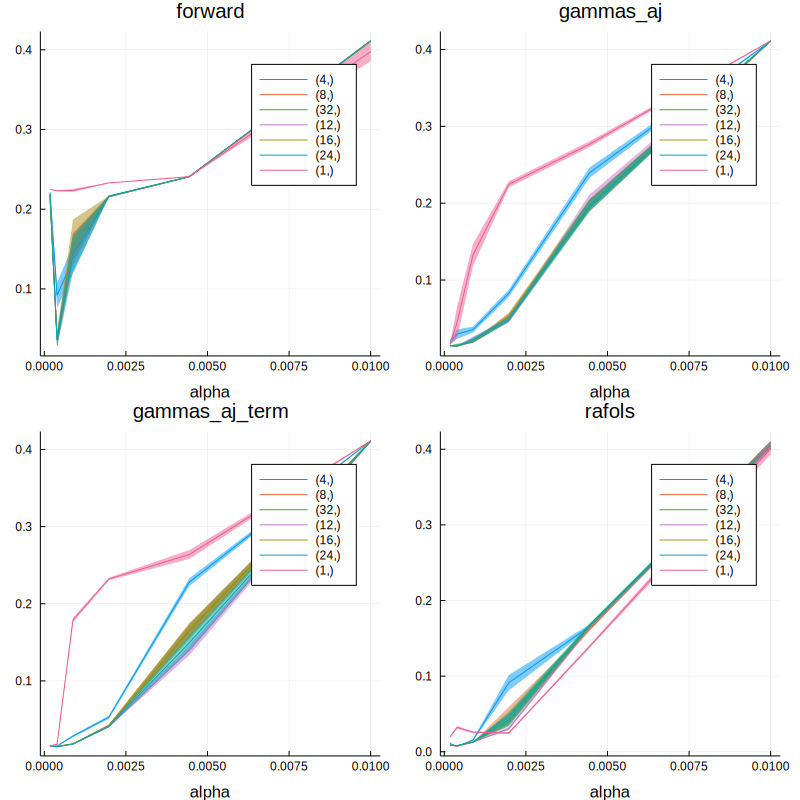

In [19]:
plot_gvfn_stepsize_sense(ic_gvfn_adam, "end")

In [20]:
ic_rnn = ItemCollection(joinpath(data_home, "compassworld_rnn/data"));

In [27]:
diff(ic_rnn)

Dict{String,Array} with 5 entries:
  "hidden"     => [35, 40, 110]
  "alpha"      => [0.00877915, 0.0131687, 0.0197531, 0.0296296, 0.0444444, 0.06…
  "truncation" => [1, 4, 8, 12, 16, 24, 32]
  "seed"       => [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  "cell"       => ["ARNN", "GRU", "LSTM"]

Line: 100%|█████████████████████████████████████████████| Time: 0:00:00


[0.21625652451739655, 0.19349755589569273, 0.12900814212316253, 0.06938445851038558, 0.052642093881500984, 0.07233643920053531, 0.08935960642555117, 0.09644422533824104, 0.0977475399750538, 10000.0, 10000.0][0.0031286650643342195, 0.009689462721975838, 0.020539527062096892, 0.017207626055550942, 0.022132192575397246, 0.027164948755114646, 0.023348790994261917, 0.027620525732610982, 0.028466066155447774, 0.0, 0.0]


Line: 100%|█████████████████████████████████████████████| Time: 0:00:00


[0.22867534258727357, 0.22673472649699722, 0.2246023138045469, 0.22233066857361336, 0.22020074752242302, 0.21946151270081385, 0.21275686615310213, 0.19812461493369446, 0.20733346471294167, 0.18424503845736953, 0.1699187255912283][0.000400465671299861, 0.0004360397958840628, 0.0004621355337387327, 0.00047024660714263164, 0.0005019017409799473, 0.0009215552309886329, 0.0031537863449157847, 0.0056370823357530155, 0.007528095689330704, 0.009338465605092175, 0.0073170679043805305]


Line: 100%|█████████████████████████████████████████████| Time: 0:00:00


[0.22847845318396165, 0.2269845290628508, 0.22506080154389174, 0.22345522062801132, 0.22035759984968822, 0.21860764361628798, 0.21572801803887015, 0.20523924365508428, 0.20055683841956845, 0.19155712805795955, 0.18242906754946106][0.0004096864634307476, 0.0004232651034745703, 0.00048801245895629405, 0.0005306869866126442, 0.000556731252065923, 0.0009314601590301591, 0.002054685043591376, 0.0038432492692005884, 0.0062065063634117, 0.006171876365358443, 0.007103572140171154]


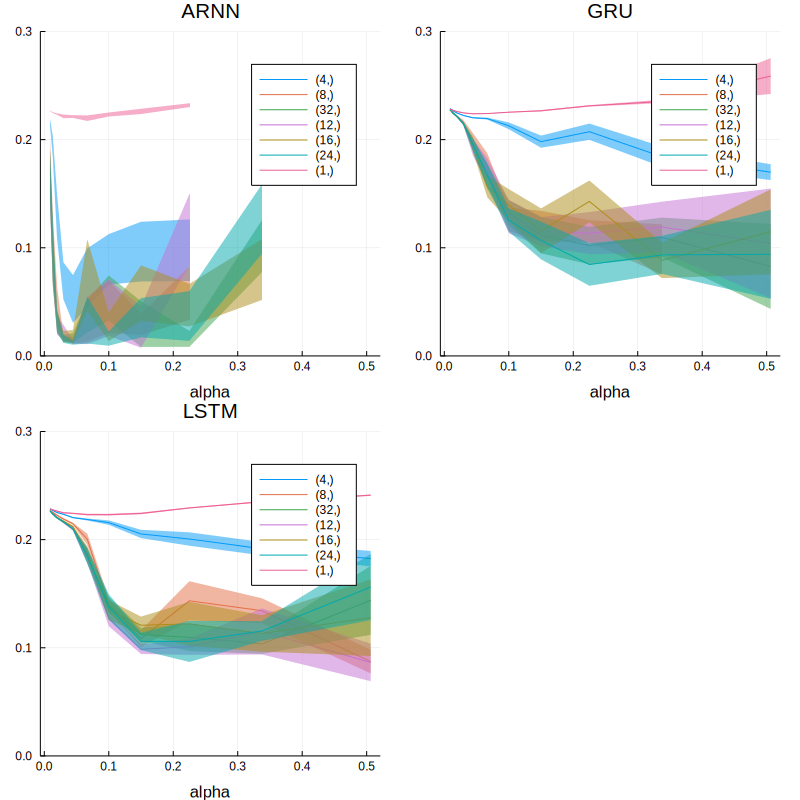

In [73]:
plot_rnn_stepsize_sens(ic_rnn, 35, "end"; ylims=(0.0,0.3))

Line: 100%|█████████████████████████████████████████████| Time: 0:00:02


[0.20230982969346462, 0.16844872064234448, 0.10262175771101723, 0.056689922206326626, 0.06433182237153148, 0.06286994453963356, 0.03456851186685184, 0.04031196700861245, 0.08754568523446887, 10000.0, 10000.0][0.01086482323097223, 0.019793932283649198, 0.020900589687114536, 0.01620932678950087, 0.0253410749776523, 0.024817229689094285, 0.01580069677669415, 0.013733581042078238, 0.03049052175910908, 0.0, 0.0]


Line: 100%|█████████████████████████████████████████████| Time: 0:00:01


[0.22858311172951992, 0.2269225234643399, 0.22402933364273378, 0.22221234265168274, 0.22025968861205114, 0.21797625217935215, 0.21563361837161663, 0.2098136032031393, 0.19535859513634019, 0.19077440409530197, 10000.0][0.0005376723669093071, 0.0005383304064780307, 0.0005670977172901189, 0.00045596751342604256, 0.00035487490320619357, 0.0005753269275216371, 0.001184688468506254, 0.00334115429903068, 0.007236757665000244, 0.012013642628042456, 0.0]


Line: 100%|█████████████████████████████████████████████| Time: 0:00:01


[0.22698581585984723, 0.2256217669670276, 0.22437235970501015, 0.22151666712637988, 0.21919988829890075, 0.2175545409982814, 0.21676215793528392, 0.2095659264718178, 0.19987362863975783, 0.1797535351303869, 0.2093729310089168][0.0007300581710901828, 0.0007742013665989221, 0.000691219797191856, 0.0009212636508817724, 0.001013665913245372, 0.0008691232177978454, 0.0014095610656317003, 0.003586853239180056, 0.006421933951903049, 0.004171704330602233, 0.022525867720212943]


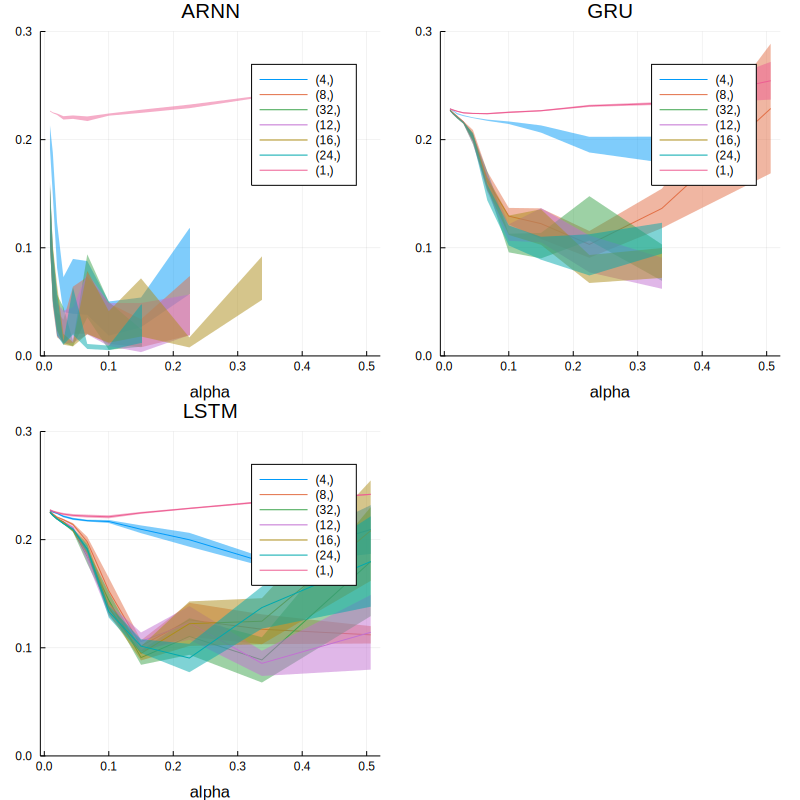

In [80]:
plot_rnn_stepsize_sens(ic_rnn, 40, "end"; ylims=(0.0,0.3))

Line: 100%|█████████████████████████████████████████████| Time: 0:00:01


[0.09199113835514555, 0.025725482804325, 0.0282196638263139, 0.018160532382145197, 0.019085963928562728, 0.012405065949501247, 0.025432599338722495, 0.03247733787893993, 10000.0, 10000.0, 10000.0][0.015400164756034453, 0.0023038985591655216, 0.010154096233925878, 0.003543040770615485, 0.006394157546060041, 0.001175022013946815, 0.013760652051283713, 0.02269415741184239, 0.0, 0.0, 0.0]


Line: 100%|█████████████████████████████████████████████| Time: 0:00:01


[0.2274419757394913, 0.22597286247178566, 0.2243800830773342, 0.22279351091321584, 0.22160337657978832, 0.22108307349548162, 0.22082688250704555, 0.22221685532996327, 0.2263826667088574, 0.2241696878305252, 10000.0][0.00034377525537477357, 0.0003976122878966552, 0.00044352058678760314, 0.00039301596750737335, 0.000502432903900604, 0.0004856743462014682, 0.0009581525177133899, 0.0026324894162189734, 0.003621213804094779, 0.00797219593356576, 0.0]


Line: 100%|█████████████████████████████████████████████| Time: 0:00:01


[0.22537821608139597, 0.222704221772351, 0.22018830829250513, 0.21809888079854095, 0.21653463154696398, 0.2162632974878957, 0.2191644910318103, 0.21933691025083815, 0.2113490157000951, 0.2594651625260731, 0.3493792706238775][0.0007015155208509436, 0.0008138012845710569, 0.000764396793928939, 0.0007438509545389326, 0.0007429268509273324, 0.0007070925396292078, 0.0010719000931345318, 0.001959665550475765, 0.006346572807477589, 0.024827237147503324, 0.03018263887645126]


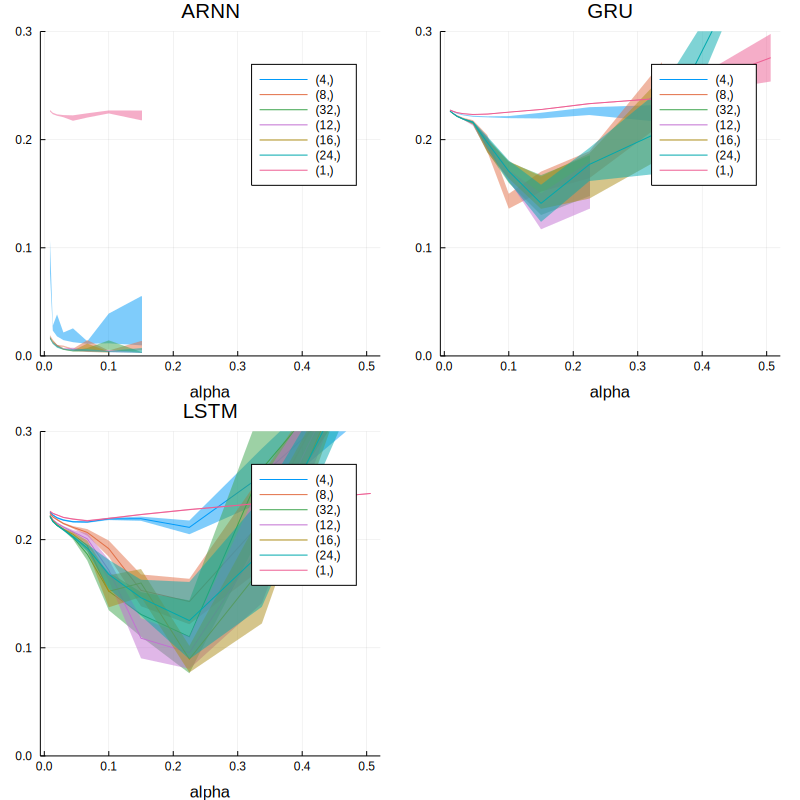

In [81]:
plot_rnn_stepsize_sens(ic_rnn, 110, "end"; ylims=(0.0,0.3))

In [41]:
ic_rnn_adam = ItemCollection(joinpath(data_home, "compassworld_rnn_adam/data"));

Line: 100%|█████████████████████████████████████████████| Time: 0:00:04


[0.011579539988114573, 0.02612941137069245, 0.17040143384907894, 0.24312901828769257, 0.27135372243787204, 0.41139258212855695][0.0010090209145870558, 0.005005222802096768, 0.02451994702938342, 0.00023800140205223127, 0.0045853395283447975, 5.922871218244207e-5]


Line: 100%|█████████████████████████████████████████████| Time: 0:00:03


[0.08053699843404447, 0.03929285053492158, 0.04278529748164889, 0.22104754749730823, 0.4020343492100521, 0.4114002007928672][0.0072700912150016435, 0.004778233218666416, 0.003398259059416496, 0.006802755800641459, 4.179167256319839e-5, 5.897755060726786e-5]


Line: 100%|█████████████████████████████████████████████| Time: 0:00:03


[0.10757928962105585, 0.05448232292772044, 0.08206924278892173, 0.1336370713366758, 0.2411136672347224, 0.3316680273580783][0.003574407186110399, 0.005187552197925503, 0.008104055313751432, 0.014694654853073868, 0.00022961619107179256, 0.022728366475908975]


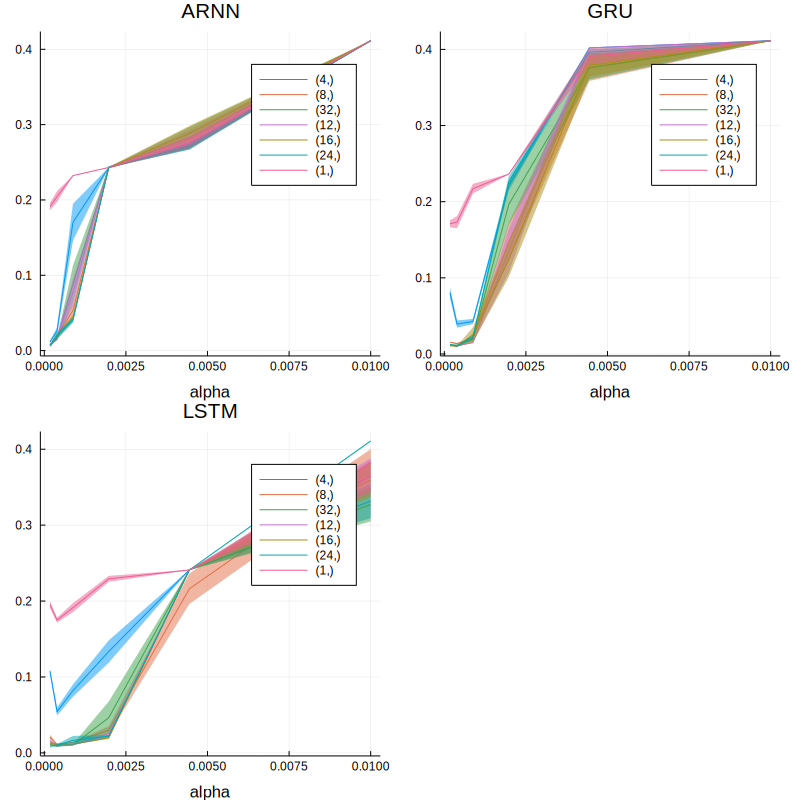

In [82]:
plot_rnn_stepsize_sens(ic_rnn_adam, 35, "end")

Line: 100%|█████████████████████████████████████████████| Time: 0:00:03


[0.012733827883796966, 0.023409920137668523, 0.20885041151515216, 0.24370552214358215, 0.3044421784777721, 0.41129319023404676][0.0013895263805876498, 0.003909190227626544, 0.012244694948425226, 0.00029941949885169946, 0.01766151483281502, 7.073210203727883e-5]


Line: 100%|█████████████████████████████████████████████| Time: 0:00:03


[0.07307440330556972, 0.03108366520982489, 0.06702144766304667, 0.2175030818135653, 0.40195961364249805, 0.41126392566759834][0.0044622882619874986, 0.002317717484366402, 0.010118062764843318, 0.00805512153940564, 5.27578598815997e-5, 7.996786035791471e-5]


Line: 100%|█████████████████████████████████████████████| Time: 0:00:03


[0.09607927674156627, 0.04629826874964581, 0.0664627307290385, 0.14848708407438715, 0.24105154442512328, 0.3877991366151713][0.007734073923370767, 0.004183472469050334, 0.0083804713027344, 0.016795119306054998, 0.0002562440814971347, 0.015057500638860577]


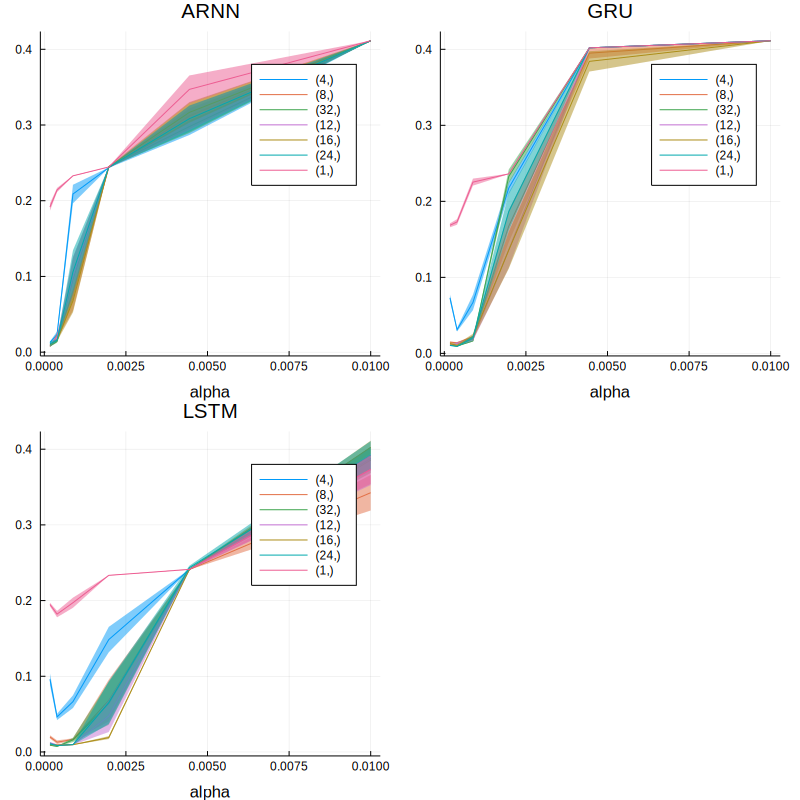

In [83]:
plot_rnn_stepsize_sens(ic_rnn_adam, 40, "end")

Line: 100%|█████████████████████████████████████████████| Time: 0:00:03


[0.014921984339394716, 0.026830672285048464, 0.22140156373925596, 0.38144945814290787, 0.40206854914048257, 0.41140739226172574][0.0013285176944579315, 0.0021976598030471225, 0.017442833555308304, 0.014180529423598027, 6.412908885697997e-5, 8.244789232411341e-5]


Line: 100%|█████████████████████████████████████████████| Time: 0:00:03


[0.017372898227439003, 0.023032533910753095, 0.21990616581960745, 0.24262061546966013, 0.4019123743661953, 0.41121819054659536][0.0016723664907898996, 0.004087646333612491, 0.00655904536864363, 0.004142169505081045, 7.789868668566927e-5, 8.993718937422389e-5]


Line: 100%|█████████████████████████████████████████████| Time: 0:00:03


[0.02963607797374048, 0.03276753819705891, 0.06745684040836612, 0.19846067829934383, 0.33762497024345156, 0.4113440345454281][0.0054794316319900695, 0.009474551858912264, 0.03691463841451989, 0.03762811253504647, 0.02630230287980564, 9.063651035569727e-5]


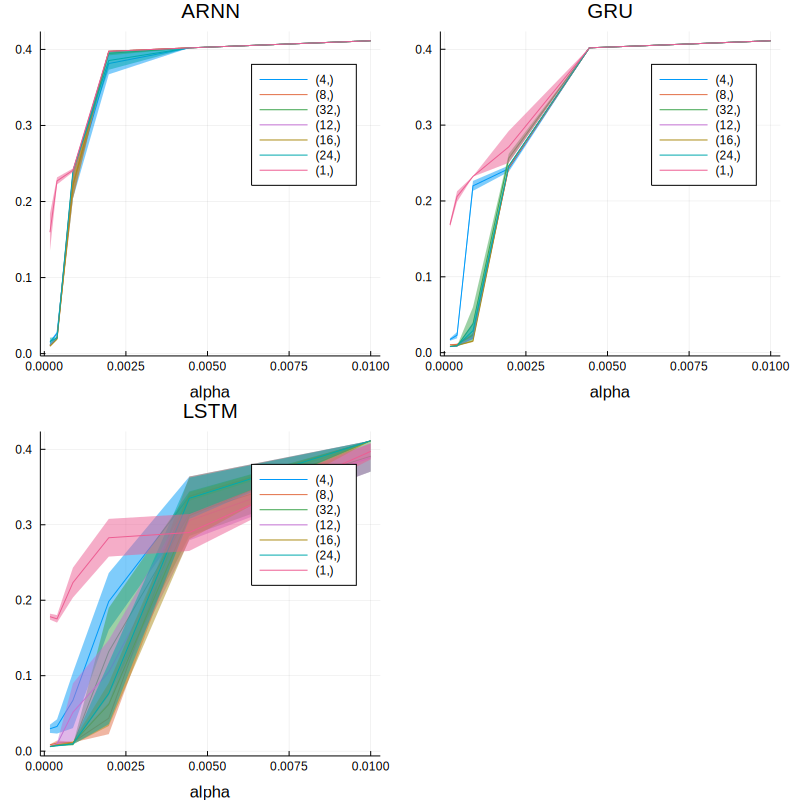

In [84]:
plot_rnn_stepsize_sens(ic_rnn_adam, 110, "end")